In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols

import math

import prep
import model

In [2]:
zillow = prep.acquire_and_prep_data()
zillow = zillow.drop(columns=['id', 'calculatedbathnbr', 'taxrate', 'County', 'State'])
zillow

,bathroomcnt,bedroomcnt,squarefeet,fullbathcnt,latitude,longitude,yearbuilt,taxvaluedollarcnt
0,2.0,3,1458,2,34.686163,-118.113100,1970,136104
1,1.0,2,1421,1,33.999877,-118.291863,1911,35606
2,3.0,4,2541,3,33.694636,-117.912245,2003,880456
3,2.0,3,1650,2,33.985377,-118.361620,1949,614000
4,1.0,2,693,1,34.112946,-118.208106,1921,274237
...,...,...,...,...,...,...,...,...
20343,2.0,2,1030,2,34.150300,-118.468000,1988,359829
20344,2.0,3,1536,2,34.058178,-117.948180,1955,297097
20345,3.0,5,2655,3,33.836898,-117.801369,1994,746963
20346,3.0,4,2305,3,33.952368,-118.441155,1949,579047


# Feature Engineering
---

## Let's make some new features and then we will see which of them works best.

### Lets create two different metrics that combine bathroom and bedroom.

In [3]:
zillow['beds_per_bath'] = zillow.bedroomcnt / zillow.bathroomcnt
zillow['baths_per_beds'] = zillow.bathroomcnt / zillow.bedroomcnt
zillow

,bathroomcnt,bedroomcnt,squarefeet,fullbathcnt,latitude,longitude,yearbuilt,taxvaluedollarcnt,beds_per_bath,baths_per_beds
0,2.0,3,1458,2,34.686163,-118.113100,1970,136104,1.500000,0.666667
1,1.0,2,1421,1,33.999877,-118.291863,1911,35606,2.000000,0.500000
2,3.0,4,2541,3,33.694636,-117.912245,2003,880456,1.333333,0.750000
3,2.0,3,1650,2,33.985377,-118.361620,1949,614000,1.500000,0.666667
4,1.0,2,693,1,34.112946,-118.208106,1921,274237,2.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...
20343,2.0,2,1030,2,34.150300,-118.468000,1988,359829,1.000000,1.000000
20344,2.0,3,1536,2,34.058178,-117.948180,1955,297097,1.500000,0.666667
20345,3.0,5,2655,3,33.836898,-117.801369,1994,746963,1.666667,0.600000
20346,3.0,4,2305,3,33.952368,-118.441155,1949,579047,1.333333,0.750000


### Next maybe a combination of square feet and bed/bath

In [4]:
zillow['sqft_per_bed_and_bath'] = zillow.squarefeet / (zillow.bathroomcnt + zillow.bedroomcnt)
zillow

,bathroomcnt,bedroomcnt,squarefeet,fullbathcnt,latitude,longitude,yearbuilt,taxvaluedollarcnt,beds_per_bath,baths_per_beds,sqft_per_bed_and_bath
0,2.0,3,1458,2,34.686163,-118.113100,1970,136104,1.500000,0.666667,291.600000
1,1.0,2,1421,1,33.999877,-118.291863,1911,35606,2.000000,0.500000,473.666667
2,3.0,4,2541,3,33.694636,-117.912245,2003,880456,1.333333,0.750000,363.000000
3,2.0,3,1650,2,33.985377,-118.361620,1949,614000,1.500000,0.666667,330.000000
4,1.0,2,693,1,34.112946,-118.208106,1921,274237,2.000000,0.500000,231.000000
...,...,...,...,...,...,...,...,...,...,...,...
20343,2.0,2,1030,2,34.150300,-118.468000,1988,359829,1.000000,1.000000,257.500000
20344,2.0,3,1536,2,34.058178,-117.948180,1955,297097,1.500000,0.666667,307.200000
20345,3.0,5,2655,3,33.836898,-117.801369,1994,746963,1.666667,0.600000,331.875000
20346,3.0,4,2305,3,33.952368,-118.441155,1949,579047,1.333333,0.750000,329.285714


### Let's split the data

In [5]:
train, test = train_test_split(zillow, train_size=.7, random_state=13)

Xtrain = train.drop(columns='taxvaluedollarcnt')
Xtest = test.drop(columns='taxvaluedollarcnt')
ytrain = train.taxvaluedollarcnt
ytest = test.taxvaluedollarcnt

Xtrain

,bathroomcnt,bedroomcnt,squarefeet,fullbathcnt,latitude,longitude,yearbuilt,beds_per_bath,baths_per_beds,sqft_per_bed_and_bath
6889,3.0,5,2453,3,34.600178,-118.171629,1993,1.666667,0.600000,306.625000
2839,3.0,3,1930,3,34.059109,-117.905709,1960,1.000000,1.000000,321.666667
2306,2.0,3,1548,2,34.306076,-118.416844,1962,1.500000,0.666667,309.600000
18402,2.5,2,1594,2,33.545011,-117.645994,2004,0.800000,1.250000,354.222222
12629,2.0,3,1691,2,33.962199,-118.396396,1941,1.500000,0.666667,338.200000
...,...,...,...,...,...,...,...,...,...,...
156,2.0,4,2044,2,33.879055,-117.908818,1955,2.000000,0.500000,340.666667
877,1.0,3,1082,1,33.836545,-118.116855,1950,3.000000,0.333333,270.500000
75,3.0,3,2149,3,34.564992,-118.059551,1989,1.000000,1.000000,358.166667
14635,2.5,3,1254,2,33.772500,-117.989000,1981,1.200000,0.833333,228.000000


In [6]:
ytrain

6889     283660
2839     266770
2306     338074
18402    113636
12629    129682
          ...  
156       81779
877       77252
75       211886
14635    340000
343      652227
Name: taxvaluedollarcnt, Length: 14126, dtype: int64

## Let's see which of these features is the best by running them through some feature selection methods

### First up lets use SelectKBest to see what our best features are

In [7]:
top_3 = SelectKBest(f_regression, k=3).fit(Xtrain, ytrain)

top_3_support = top_3.get_support()

Xtrain.loc[:,top_3_support].columns.tolist()

['bathroomcnt', 'squarefeet', 'fullbathcnt']

### Next lets run RFE to see what it says

In [8]:
lm = LinearRegression()

rfe = RFE(lm, 1)

rfe.fit(Xtrain, ytrain)

ranks = rfe.ranking_
names = Xtrain.columns.tolist()

pd.DataFrame({'features': names, 'rank': ranks}).set_index('rank')

,features
rank,
1,bathroomcnt
5,bedroomcnt
10,squarefeet
7,fullbathcnt
2,latitude
6,longitude
9,yearbuilt
4,beds_per_bath
3,baths_per_beds


Now we can run these through some models and see how they work out.

# Modeling
---

## First let's start by modeling at each of the features individually

### Well set up a predictions dataframe to add our predictions onto and we will start it with a baseline so we can see how we do

In [9]:
predictions = pd.DataFrame(ytrain)
predictions['baseline'] = ytrain.mean()
predictions

,taxvaluedollarcnt,baseline
6889,283660,506255.093374
2839,266770,506255.093374
2306,338074,506255.093374
18402,113636,506255.093374
12629,129682,506255.093374
...,...,...
156,81779,506255.093374
877,77252,506255.093374
75,211886,506255.093374
14635,340000,506255.093374


### Now lets loop over the columns and build a model for each

In [10]:
for col in Xtrain.columns.tolist():
    X = Xtrain[[col]]
    y = ytrain
    
    lm = LinearRegression()
    lm.fit(X, y)
    
    predictions[f'lm_{col}'] = lm.predict(X)

In [11]:
predictions

,taxvaluedollarcnt,baseline,lm_bathroomcnt,lm_bedroomcnt,lm_squarefeet,lm_fullbathcnt,lm_latitude,lm_longitude,lm_yearbuilt,lm_beds_per_bath,lm_baths_per_beds,lm_sqft_per_bed_and_bath
6889,283660,506255.093374,738804.000925,847685.450185,780909.790979,763020.594014,349211.052145,505063.272699,590920.122502,454092.995305,410975.462295,437405.234720
2839,266770,506255.093374,738804.000925,499513.985084,566237.821085,763020.594014,491949.051533,492526.989527,472056.018055,612472.745679,613123.828855,486857.804287
2306,338074,506255.093374,405944.960691,499513.985084,409441.085904,430566.931132,426797.332446,516623.458762,479259.903173,493687.932898,444666.856721,447186.158451
18402,113636,506255.093374,572374.480808,325428.252533,428322.368151,430566.931132,627571.901871,480283.229057,630541.490651,659986.670791,739466.557956,593890.881910
12629,129682,506255.093374,405944.960691,499513.985084,468137.245933,430566.931132,517514.625463,515659.477421,403619.109434,493687.932898,444666.856721,541214.534493
...,...,...,...,...,...,...,...,...,...,...,...,...
156,81779,506255.093374,405944.960691,673599.717634,613030.564045,430566.931132,539448.626896,492673.557308,454046.305260,374903.120117,360438.370654,549324.207951
877,77252,506255.093374,73085.920457,499513.985084,218165.487490,98113.268250,550663.078942,502481.058595,436036.592465,137333.494556,276209.884588,318636.875122
75,211886,506255.093374,738804.000925,499513.985084,656129.143087,763020.594014,358493.378884,499779.572543,576512.352266,612472.745679,613123.828855,606859.053431
14635,340000,506255.093374,572374.480808,499513.985084,288765.064587,430566.931132,567558.623079,496453.582343,547696.811794,564958.820567,528895.342788,178909.393242


### Let's see how they did

In [12]:
predictions.apply(lambda col: math.sqrt(mean_squared_error(predictions.taxvaluedollarcnt, col))).sort_values()

taxvaluedollarcnt                0.000000
lm_squarefeet               527073.231767
lm_bathroomcnt              567518.873929
lm_fullbathcnt              571374.968844
lm_sqft_per_bed_and_bath    584385.161923
lm_bedroomcnt               625867.078325
lm_baths_per_beds           632771.694321
lm_beds_per_bath            635675.960675
lm_yearbuilt                643970.773295
lm_latitude                 645454.572099
lm_longitude                649186.629364
baseline                    649412.158395
dtype: float64

### Not so great so lets see if it gets better if we use squarefeet with another variable

In [13]:
for col in Xtrain.columns.tolist():
    X = Xtrain[['squarefeet', col]]
    y = ytrain
    
    lm = LinearRegression()
    lm.fit(X, y)
    
    predictions[f'lm_sqft_and_{col}'] = lm.predict(X)

In [14]:
predictions.apply(lambda col: math.sqrt(mean_squared_error(predictions.taxvaluedollarcnt, col))).sort_values()

taxvaluedollarcnt                         0.000000
lm_sqft_and_bedroomcnt               516318.541781
lm_sqft_and_baths_per_beds           521918.549792
lm_sqft_and_latitude                 522268.252922
lm_sqft_and_beds_per_bath            525135.223686
lm_sqft_and_yearbuilt                526467.524586
lm_sqft_and_sqft_per_bed_and_bath    526586.514152
lm_sqft_and_longitude                526809.977581
lm_sqft_and_fullbathcnt              526824.799311
lm_sqft_and_bathroomcnt              526918.205412
lm_squarefeet                        527073.231767
lm_sqft_and_squarefeet               527073.231767
lm_bathroomcnt                       567518.873929
lm_fullbathcnt                       571374.968844
lm_sqft_per_bed_and_bath             584385.161923
lm_bedroomcnt                        625867.078325
lm_baths_per_beds                    632771.694321
lm_beds_per_bath                     635675.960675
lm_yearbuilt                         643970.773295
lm_latitude                    

### Alright lets do one more addition and see if it gets any better this time we will add sqft and bedroomcnt to each and see what happens

In [15]:
for col in Xtrain.columns.tolist():
    X = Xtrain[['squarefeet', 'bedroomcnt', col]]
    y = ytrain
    
    lm = LinearRegression()
    lm.fit(X, y)
    
    predictions[f'lm_sqft_bedcnt_{col}'] = lm.predict(X)

In [16]:
predictions.apply(lambda col: math.sqrt(mean_squared_error(predictions.taxvaluedollarcnt, col))).sort_values()

taxvaluedollarcnt                            0.000000
lm_sqft_bedcnt_sqft_per_bed_and_bath    511250.984521
lm_sqft_bedcnt_latitude                 512810.207198
lm_sqft_bedcnt_yearbuilt                515057.870059
lm_sqft_bedcnt_fullbathcnt              515478.241414
lm_sqft_bedcnt_bathroomcnt              515689.255015
lm_sqft_bedcnt_longitude                516021.059439
lm_sqft_bedcnt_beds_per_bath            516147.861756
lm_sqft_bedcnt_baths_per_beds           516237.528814
lm_sqft_bedcnt_bedroomcnt               516318.541781
lm_sqft_and_bedroomcnt                  516318.541781
lm_sqft_bedcnt_squarefeet               516393.721994
lm_sqft_and_baths_per_beds              521918.549792
lm_sqft_and_latitude                    522268.252922
lm_sqft_and_beds_per_bath               525135.223686
lm_sqft_and_yearbuilt                   526467.524586
lm_sqft_and_sqft_per_bed_and_bath       526586.514152
lm_sqft_and_longitude                   526809.977581
lm_sqft_and_fullbathcnt     

In [17]:
for col in Xtrain.columns.tolist():
    X = Xtrain[['squarefeet', 'bedroomcnt', col]]
    y = ytrain
    
    lm = LinearRegression()
    lm.fit(X, y)
    
    predictions[f'lm_sqft_bedcnt_{col}'] = lm.predict(X)

### So our best model seems to be squarefeet, bedroomcnt, and sqft_per_bed_and_bath so lets check it out in more detail

In [18]:
X = train[['squarefeet', 'bedroomcnt', 'sqft_per_bed_and_bath']]
y = ytrain

lm = LinearRegression()
lm.fit(X, y)

predictions = pd.DataFrame(ytrain)
predictions['baseline'] = ytrain.mean()
predictions['best_model'] = lm.predict(X)

In [19]:
predictions

,taxvaluedollarcnt,baseline,best_model
6889,283660,506255.093374,535765.240058
2839,266770,506255.093374,625933.435442
2306,338074,506255.093374,382577.619705
18402,113636,506255.093374,578302.755568
12629,129682,506255.093374,433883.940622
...,...,...,...
156,81779,506255.093374,435363.689321
877,77252,506255.093374,125992.648709
75,211886,506255.093374,716569.445980
14635,340000,506255.093374,314767.773168


In [20]:
def zplot_residuals(actual, predicted, color):
    residuals = actual - predicted

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].hist(residuals, bins=100, ec='black', fc='white')
    axs[0, 0].set(title="Distribution of Residuals")

    axs[0, 1].scatter(actual, predicted, marker='.', c=color)
    axs[0, 1].plot([actual.min(), actual.max()], [actual.min(), actual.max()], ls=':', color='black')
    axs[0, 1].set(title="Actual vs Predicted", xlabel="$y$", ylabel=r"$\hat{y}$")

    axs[1, 0].scatter(actual, residuals, marker='.', c=color)
    axs[1, 0].hlines(0, actual.min(), actual.max(), ls=':', color='black')
    axs[1, 0].set(title="Actual vs Residuals", xlabel="$y$", ylabel=r"$y - \hat{y}$")

    axs[1, 1].scatter(predicted, residuals, marker='.', c=color)
    axs[1, 1].hlines(0, actual.min(), actual.max(), ls=':', color='black')
    axs[1, 1].set(
        title="Predicted vs Residuals", xlabel=r"$\hat{y}$", ylabel=r"$y - \hat{y}$"
    )

    return fig, axs

(<Figure size 864x864 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x102770ed0>,
       dtype=object))

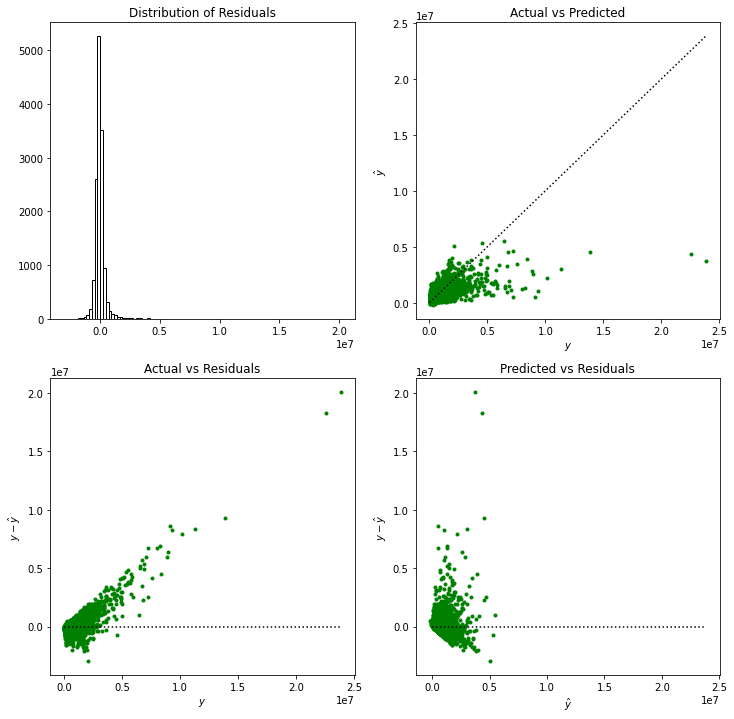

In [21]:
zplot_residuals(predictions.taxvaluedollarcnt, predictions.best_model, 'green')

So it looks like outliers are definitely having an effect on our model so we need to dial in the cost that we want to predict.

# Let's see how our model does on the test data

In [22]:
predictions = pd.DataFrame(ytest)
predictions['baseline'] = ytest.mean()

Xtest = test[['squarefeet', 'bedroomcnt', 'sqft_per_bed_and_bath']]

predictions['best_model'] = lm.predict(Xtest)

In [23]:
pd.options.display.float_format = '{:.3f}'.format
predictions

,taxvaluedollarcnt,baseline,best_model
9461,1206479,500988.684,616841.524
2410,511272,500988.684,298980.607
13165,3324064,500988.684,1453909.692
9974,54836,500988.684,426156.991
10305,236000,500988.684,173046.911
...,...,...,...
2674,1583432,500988.684,1355763.937
4004,372000,500988.684,324526.777
15525,471024,500988.684,176538.758
9473,435472,500988.684,486929.045


In [24]:
predictions.apply(lambda col: math.sqrt(mean_squared_error(predictions.taxvaluedollarcnt, col))).sort_values()

taxvaluedollarcnt        0.000
best_model          494653.422
baseline            668240.999
dtype: float64

(<Figure size 864x864 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x102732850>,
       dtype=object))

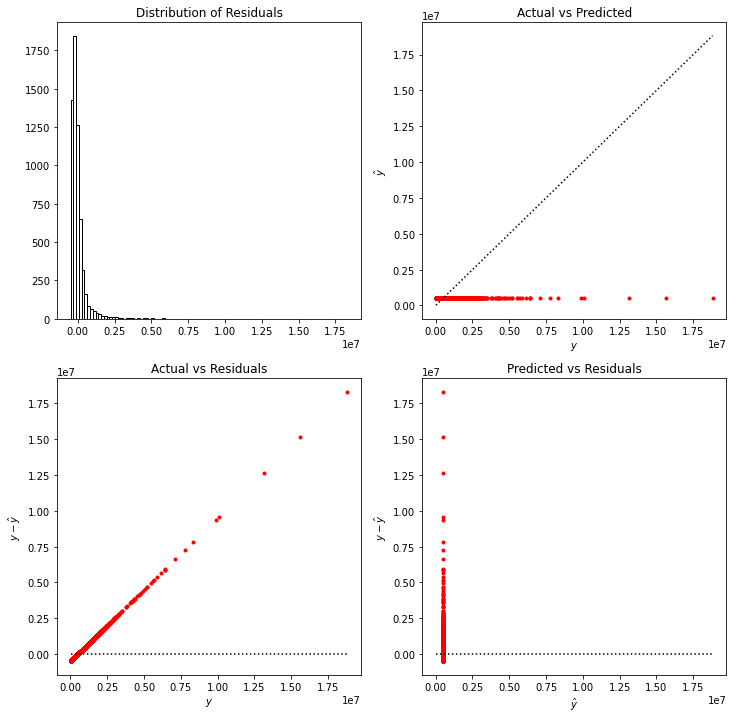

In [25]:
zplot_residuals(predictions.taxvaluedollarcnt, predictions.baseline, 'red')

(<Figure size 864x864 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b4f4210>,
       dtype=object))

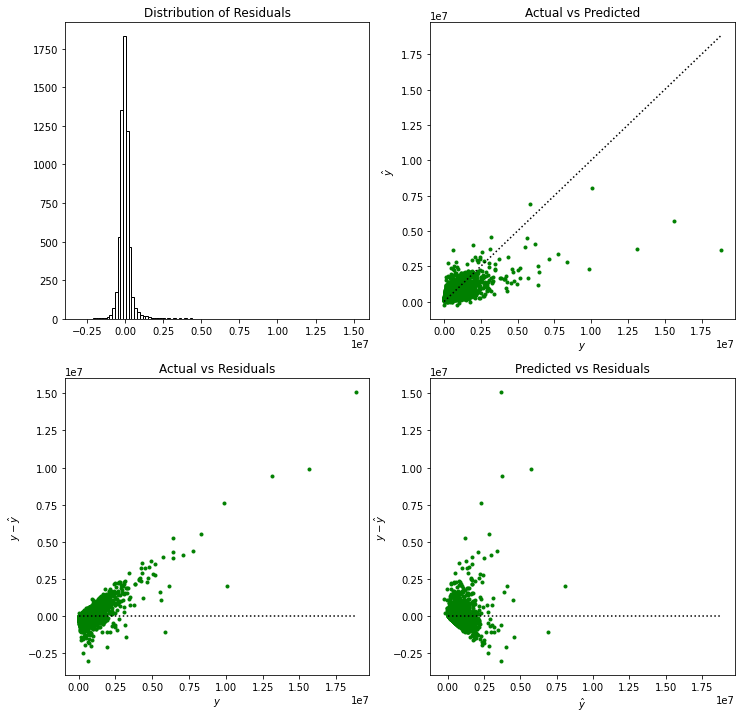

In [26]:
zplot_residuals(predictions.taxvaluedollarcnt, predictions.best_model, 'green')

## Let's reproduce the model with ols so we can get $R^2$ and the p-value 

In [27]:
ols_model = ols('taxvaluedollarcnt ~ squarefeet + bedroomcnt + sqft_per_bed_and_bath', data=train).fit()

In [28]:
r2 = ols_model.rsquared
r2

0.38023437577779495

In [29]:
ols_model.f_pvalue

0.0

In [30]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     2888.
Date:                Sat, 11 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:37:44   Log-Likelihood:            -2.0572e+05
No. Observations:               14126   AIC:                         4.115e+05
Df Residuals:                   14122   BIC:                         4.115e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              5.404e+05   3.37e+04     16.037      0.000    4.74e+05    6.06e+05
squarefeet              689.2511     12.240     56.313      0.000     665.260     713.243
bedroomcnt            -2.378e+05   8107.608    -29.324      0.000   -2.54e+05   -2.22e+05
sqft_per_bed_and_bath -1652.3280     98.509    -16.773      0.000   -1845.419   -1459.237
==============================================================================
Omnibus:                    24433.945   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         66211282.127
Skew:                          11.703   Prob(JB):                         0.00
Kurtosis:                     337.582   Cond. No.                     1.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Lastly, lets test our model.py functions

In [31]:
lm_model = model.get_model()
lm_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
pred_df = model.make_predictions(lm_model, ytest, Xtest)
pred_df

,taxvaluedollarcnt,baseline,model_predictions
9461,1206479,500988.684,616841.524
2410,511272,500988.684,298980.607
13165,3324064,500988.684,1453909.692
9974,54836,500988.684,426156.991
10305,236000,500988.684,173046.911
...,...,...,...
2674,1583432,500988.684,1355763.937
4004,372000,500988.684,324526.777
15525,471024,500988.684,176538.758
9473,435472,500988.684,486929.045


In [33]:
model.evaluate_model(pred_df)

Baseline RMSE: 668240.9987778572
Baseline RMSE: 494653.4222273066
Model is better than baseline
